In [2]:
import deorbit
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
from deorbit.utils.plotting import plot_trajectories, plot_height, plot_crash_site, plot_from_last_measurements
import numpy as np
from deorbit.observer import Observer
from deorbit.utils import plotting   
from mpl_toolkits.basemap import Basemap


WORK IN PROGRESS PLEASE IGNORE FOR NOW

In [3]:
save_path = "eg/EKF_example_noise_2s/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

if sim_data is None or sim_config is None:
    np.random.seed(0)
    sim = deorbit.simulator.run(
        "RK4",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        noise_types = {"gaussian": {"noise_strength": 0.005}, "impulse": {"impulse_strength": 0.03, "impulse_probability": 1e-5}},
        time_step=2,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Loaded data from file


100%|██████████| 69/69 [00:05<00:00, 12.40it/s]


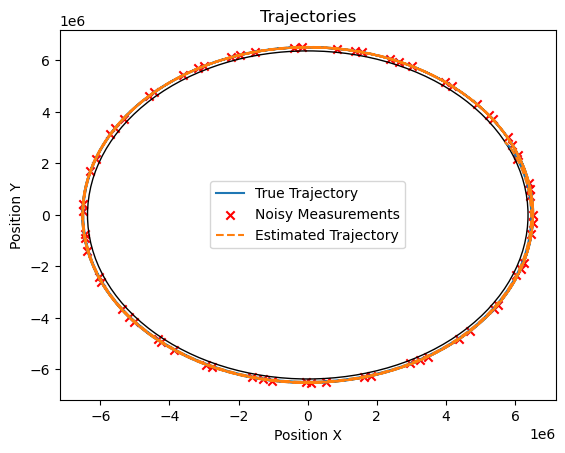

In [4]:
obs = Observer(number_of_radars=10, radar_variance_per_m=1)
sim_states = sim_data.state_array()
sim_times = sim_data.times

obs.run(sim_states=sim_states, sim_times=sim_times, checking_interval=100)

observation_times = obs.observed_times
observation_states = obs.observed_states
observed_covariances = obs.observed_covariances

observations = (observation_states, observation_times)

# Define process and measurement noise covariance matrices
Q = np.diag([0.1, 0.1, 0.01, 0.01])#process noise
P = np.eye(4) #error covariance matrix - represents uncertainty in state estimation
R = observed_covariances

# Measurement matrix H (assuming all states are measured directly)
H = np.eye(4)

dt = sim_config.simulation_method_kwargs.time_step

ekf = EKF()

estimated_traj, uncertainties, estimated_times = ekf.run(observations, dt=dt, Q=Q, R=R, P=P, H=H)

true_traj = sim_data.state_array()[:, :2]

crash_coords = true_traj[-1, :]

plot_trajectories(true_traj, observations=observation_states, estimated_traj=estimated_traj)

In [8]:
#Can play around with func directly if easier

def plot_heatmap(true_traj, estimated_traj, uncertainties):
    
    """ defining a grid covering the Earth's surface, where each grid point represents a potential impact location. 
    For each grid point, the function calculates the distance between the mean trajectory and the grid point,
    then computes the probability density function (PDF) using the uncertainties. 
    where the uncertainty matrix is singular, indicating numerical instability, the function sets the PDF to zero.
    After iterating over  grid points, the heatmap is plotted on a map projection using Basemap, 
    so basiclaly tells you likelihood of impact across different geographical areas."""
    
    crash_coords = true_traj[-1, :]
    dim = estimated_traj.shape[1] // 2
    mean_trajectory = estimated_traj[:, :dim]  # Extract position data
    
    # Define grid --> Projecting to 2D map?
    lats = np.linspace(-90, 90, 100)
    lons = np.linspace(-180, 180, 100)
    grid_lats, grid_lons = np.meshgrid(lats, lons)
    
    # Initialize heatmap array
    heatmap = np.zeros_like(grid_lats)
    
    # Iterate over each grid point
    for i in range(len(lats-1)):
        for j in range(len(lons-1)):
            # dist between mean trajectory and grid point
            dist = np.linalg.norm(mean_trajectory[:, :dim] - [lons[j], lats[i]], axis=1)
            dist = dist[:, np.newaxis]  # Column vector
            
            # Compute PDF based on uncertainty matrix
            try:
                inv_uncertainty_matrix = np.linalg.inv(uncertainties)  # Invert uncertainty matrix
                pdf = np.exp(-0.5 * np.sum(dist @ inv_uncertainty_matrix * dist, axis=1))
            except np.linalg.LinAlgError:
                pdf = np.zeros_like(dist.flatten())  # If matrix is singular, set PDF to zero I kept getting LinAlgError: Singular matrix so had to add this condition
            
            # Update heatmap 
            heatmap[i, j] = np.mean(pdf)

    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    m = Basemap(projection='mill', lon_0=0)
    m.drawcoastlines()
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0])
    m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1])
    x, y = m(grid_lons, grid_lats)
    m.pcolormesh(x, y, heatmap, cmap='hot_r')
    plt.colorbar(label='Probability Density')
    plt.title('Impact Location Heatmap')
    plt.show()
    
    return print("Heatmap shape:", heatmap.shape), print("Length of lats:", len(lats)), print("Length of lons:", len(lons)) # Debugging 

Uncertainties shape: (10808, 4, 4)


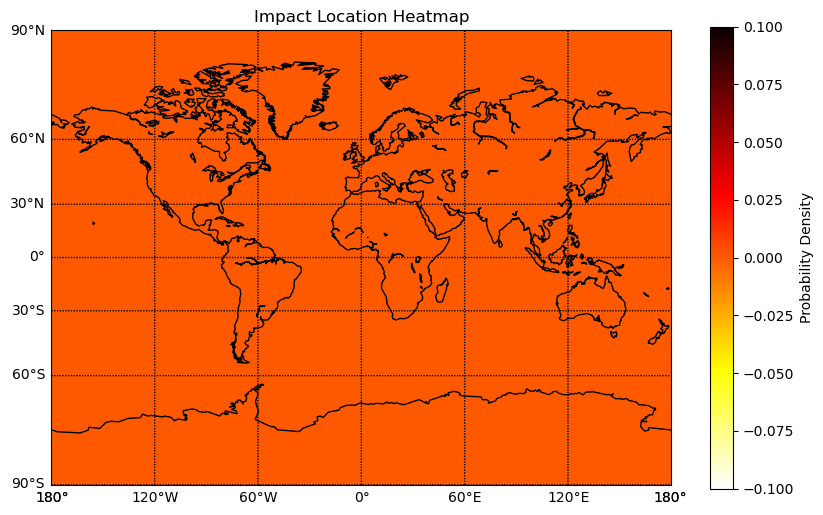

Heatmap shape: (100, 100)
Length of lats: 100
Length of lons: 100


In [7]:
print("Uncertainties shape:", uncertainties.shape)


# Call the function and store the returned values
heatmap_shape, lats_length, lons_length = plotting.plot_heatmap(true_traj, estimated_traj, uncertainties)


In [ ]:
# can 